# Importing Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

In [29]:
data = pd.read_csv('/content/ALL_FAIL_LOG_RATE_Add_Random.csv')

# Preprocessing and EDA

In [30]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (8638, 15)

Columns:
 Index(['LineNO', 'TimeUS', 'RDes', 'R', 'Rout', 'PDes', 'P', 'POut', 'YDes',
       'Y', 'YOut', 'ADes', 'A', 'AOut', 'labels'],
      dtype='object')

Sample Data:
    LineNO     TimeUS       RDes          R      Rout       PDes          P  \
0  340420  410163369   2.452054  -37.63402  0.667108  -4.356002 -140.66080   
1  184713  237063470  10.910090 -189.01700  1.072000 -20.874800  -16.95706   
2  242529  301363573  23.553730  -19.57057  0.676337  44.378560 -112.69140   
3  363378  435663998  -3.773822 -101.38740  0.891620  -1.013024 -109.76890   
4  125844  171663807   1.517852  -56.59896 -0.087987 -15.486790  133.12580   

       POut       YDes          Y      YOut         ADes            A  \
0  0.638001   3.448024   1.897259  0.001398   -76.753060   -25.643830   
1 -0.648717  -1.558685   1.089940 -0.003160  9274.284000 -1036.640000   
2  0.612959 -48.748870 -21.143700 -0.018582   356.041700 -1125.106000   
3  0.233091  -5.167070   4.293900 -0

In [31]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNO      int64
TimeUS      int64
RDes      float64
R         float64
Rout      float64
PDes      float64
P         float64
POut      float64
YDes      float64
Y         float64
YOut      float64
ADes      float64
A         float64
AOut      float64
labels      int64
dtype: object



Label Distribution:
 labels
0    4058
4    1377
2    1236
1    1138
3     829
Name: count, dtype: int64


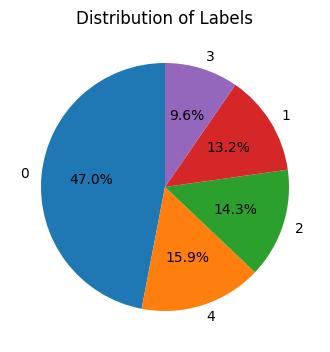

In [32]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_counts)
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Labels')
    plt.show()

In [33]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [34]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [35]:
X.shape

(8638, 14)

In [36]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [38]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [39]:
X_reshaped.shape

(8638, 1, 14)

#Model

In [40]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [41]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [42]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [43]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [44]:
print(input_shape)

(1, 14)


In [45]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1


Training fold 1...
Validation Accuracy for fold 1: 0.9728
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 2...
Validation Accuracy for fold 2: 0.9578
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 3...
Validation Accuracy for fold 3: 0.9832
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training fold 4...
Validation Accuracy for fold 4: 0.9693
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Training fold 5...
Validation Accuracy for fold 5: 0.9734
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [46]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 1, 14)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 1, 64)               │           3,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_17 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_5 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,553 (381.07 KB)

 Trainable params: 32,389 (126.52 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 64,780 (253.05 KB)

In [47]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.9713


In [48]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9699
Label 1 Accuracy: 0.9621
Label 2 Accuracy: 0.9701
Label 3 Accuracy: 0.9517
Label 4 Accuracy: 0.9957


In [49]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Get the label distribution after training
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(4,5))
plt.pie(pd.Series(y_pred_classes).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Label Distribution of Predictions After Training')
plt.show()

In [50]:
  # Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9709    0.9722    0.9715       790
           1     1.0000    0.9921    0.9960       253
           2     0.9760    0.9494    0.9625       257
           3     0.9662    0.9470    0.9565       151
           4     0.9582    0.9964    0.9769       276

    accuracy                         0.9734      1727
   macro avg     0.9743    0.9714    0.9727      1727
weighted avg     0.9735    0.9734    0.9733      1727



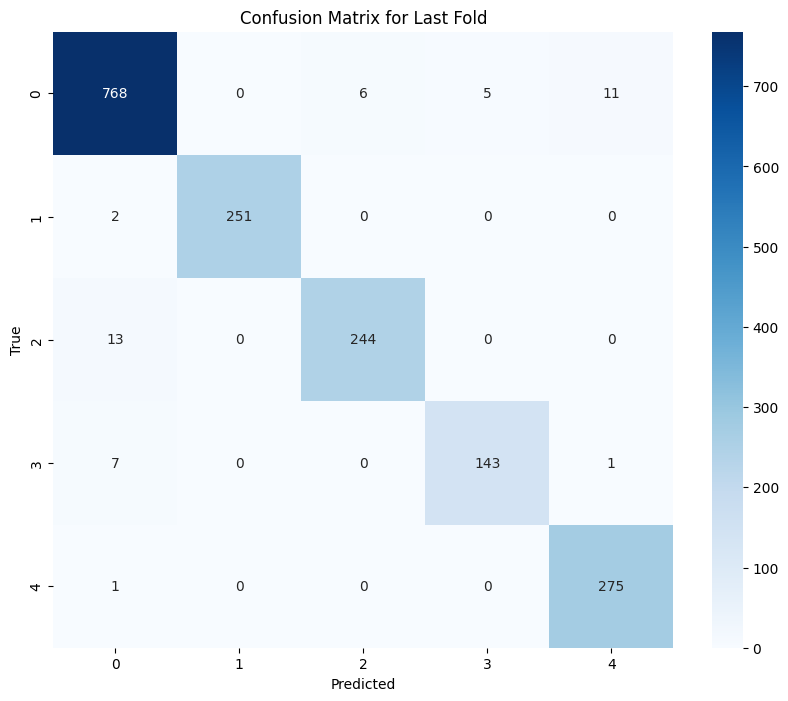

In [51]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Distribution of predicted labels (entire dataset):
0    3955
4    1435
1    1255
2    1250
3     740
Name: count, dtype: int64


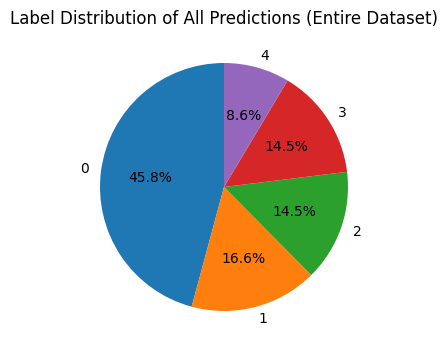

In [52]:
# Create lists to collect predictions
all_y_pred = []
all_y_true = []

for train_index, val_index in kf.split(X_reshaped):
    # ... (training code for each fold remains the same)

    # Predictions from this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Append predictions and true labels for this fold
    all_y_pred.extend(y_pred_classes)
    all_y_true.extend(y_true_classes)

# After all folds are complete, you can now examine the distribution
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Distribution of predictions across all data
print("\nDistribution of predicted labels (entire dataset):")
print(pd.Series(all_y_pred).value_counts())

# Plotting the pie chart for all predictions
plt.figure(figsize=(4,5))
plt.pie(pd.Series(all_y_pred).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution of All Predictions (Entire Dataset)')
plt.show()



In [69]:
#Misclassification
feature_names=['LineNO', 'TimeUS', 'RDes', 'R', 'Rout', 'PDes', 'P', 'POut', 'YDes',
       'Y', 'YOut', 'ADes', 'A', 'AOut']

# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
     Index  Actual_Label  Predicted_Label    LineNO    TimeUS      RDes  \
0        3             0                4  1.405817  1.322566  0.044826   
1      126             2                0  0.164287  0.075183 -3.764424   
2      151             2                0  0.304647  0.216333 -0.595220   
3      249             2                0  0.324521  0.236284 -0.024066   
4      478             2                0  0.303128  0.214799 -0.633788   
..     ...           ...              ...       ...       ...       ...   
138   8432             4                0  0.700904  0.840791 -0.199277   
139   8459             0                4  0.654231  0.794001 -0.010531   
140   8462             2                0  0.121526  0.258528 -0.353420   
141   8484             0                4  0.653475  0.793228  0.281365   
142   8487             0                4  0.685621  0.825448  0.228218   

            R      Rout      PDes         P      POut     

# XAI

In [54]:
import shap
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return model.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:200]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=True)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [55]:
X_flat.shape

(8638, 14)

In [56]:
shap_values_kernel.shape

(200, 14, 5)

In [57]:
data_point_index=0
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.5115846850983821, -0.08653894122453935, -0.07949135766442837, -0.02758017228137477, -0.31812014642816044]
Feature 1: [-0.22129043390138997, -0.08498541055568784, -0.07492366580918229, 0.02217720652617783, 0.35802162813025545]
Feature 2: [0.049701038088868076, 0.0, -0.00600319703036421, -0.04193822437829141, 0.0]
Feature 3: [0.052579937390204036, 0.0, 0.0031754323940537334, 0.0, -0.055527774092697456]
Feature 4: [0.0, -0.0009291266770992553, -0.002959425669062579, -0.01541808522455331, 0.05398636230749587]
Feature 5: [0.0, -0.000909811447812872, -0.003038178851107821, -0.01831214187988976, 0.014823712568816295]
Feature 6: [0.02489705346028981, -0.017927864079599835, -0.004397894308787313, 0.0, 0.0]
Feature 7: [0.016812193345727144, -0.005599025024438841, 0.0020117620366288114, 0.0, -0.014165730791493804]
Feature 8: [0.03115754510321169, 0.0, 0.0, -0.059558231472444885, 0.025382622105051898]
Feature 9: [0.021719870601958565, -0.00170820

In [58]:
data_point_index = 101  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")

SHAP values for the first data point:
Feature 0: [0.007449090316954264, -0.14451476763531024, 0.015773320372971904, 0.0, 0.1238263366311533]
Feature 1: [0.5640683893134034, -0.013354027742590074, -0.11927497455415324, -0.188121771575987, -0.2430523731890403]
Feature 2: [0.04335823039009808, -0.01581219477941446, -0.012430767815754676, -0.017811176786780337, 0.0]
Feature 3: [-0.015957422436921935, 0.0, 0.0, -0.0029266603769061983, 0.011864020244598133]
Feature 4: [0.050421280431724176, -0.03967670028182417, 0.0, 0.0, 0.0]
Feature 5: [0.0, 0.0, 0.0020818169108573203, -0.004048493467475196, 0.005196547096025246]
Feature 6: [0.0, 0.017912431332468174, 0.007248556564755441, -0.027801099680761367, 0.0]
Feature 7: [0.0, -0.009923423209846748, -0.006064753406583369, 0.0, 0.01634080570399833]
Feature 8: [0.002408755194181489, 0.009534710975625832, 0.0, -0.02362856704970039, 0.013133951125076393]
Feature 9: [0.00888450451649704, 0.0, 0.005560904227544264, -0.020741159761263124, 0.007675394521617

In [59]:
data_point_index = 199  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.07278014285433054, -0.02375520168623364, -0.04259601895227273, 0.0, 0.0]
Feature 1: [-0.14597360931863168, -0.0248896087886901, -0.04259201422388163, 0.13024615068321166, 0.08442982081608251]
Feature 2: [0.0, 0.0, 0.0, 0.0, 0.0]
Feature 3: [-0.05439077138259819, -0.002745478372680854, -0.02327554744622669, 0.0407385253505847, 0.04094718872034789]
Feature 4: [0.0, -0.005263357240838661, 0.0, 0.01412527450860368, -0.007897811444308823]
Feature 5: [0.025230016914467645, 0.0, -0.006003960279550939, 0.0, -0.017194509643544815]
Feature 6: [0.00999200300671571, -0.029542883498846113, -0.03946390755221833, 0.11649077140630804, -0.05613491917178849]
Feature 7: [0.014164226096798314, -0.00352055842933875, 0.0, 0.0, -0.0030668162093241656]
Feature 8: [0.0, -0.022800285129702898, 0.0, 0.046018451982469136, -0.041172599786759]
Feature 9: [-0.025899840441593915, -0.027009322847137147, -0.08824643085290282, 0.28075234788778475, -0.1380696745386963]


In [61]:
X_flat.shape

(8638, 14)

In [62]:
shap_values_kernel.shape

(200, 14, 5)

In [63]:
shap_importance_per_class = np.mean(np.abs(shap_values_kernel), axis=0)  # Shape: (16, 5)


In [64]:
shap_importance_per_class.shape

(14, 5)

In [65]:
feature_names_for_shap = [name for name in feature_names if name != 'labels']

In [66]:
# Convert to DataFrame for better readability
shap_df = pd.DataFrame(shap_importance_per_class, columns=['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly'], index=feature_names_for_shap)

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]:  # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))



Top Contributing Features for GPS Anomaly:
LineNO    0.095546
TimeUS    0.074965
A         0.028805
AOut      0.024238
P         0.019938
POut      0.017877
YDes      0.014640
ADes      0.013509
R         0.012879
Rout      0.012379
RDes      0.007141
YOut      0.002659
Y         0.001690
PDes      0.001598
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
A         0.132094
TimeUS    0.100452
LineNO    0.041314
AOut      0.018461
ADes      0.011268
RDes      0.008058
POut      0.006457
R         0.006315
P         0.005950
Rout      0.005761
Y         0.005556
YOut      0.004414
PDes      0.003201
YDes      0.003087
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
TimeUS    0.098047
AOut      0.061849
YDes      0.040042
A         0.031621
RDes      0.028038
Y         0.027984
P         0.016308
LineNO    0.015299
ADes      0.015115
PDes      0.009912
R         0.006487
YOut      0.005058
Rout      0.00395

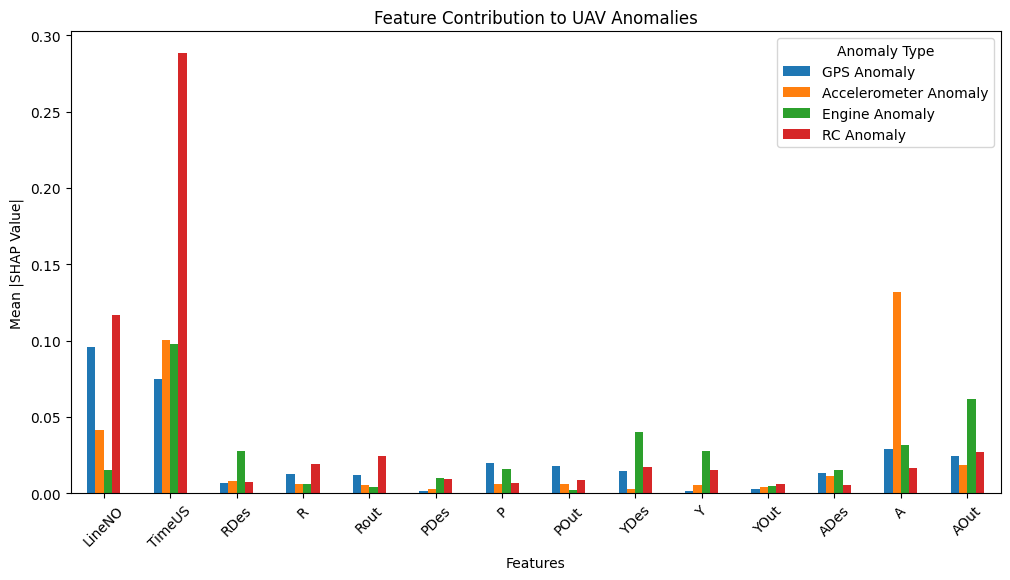

In [67]:
shap_df.iloc[:, 1:].plot(kind='bar', figsize=(12, 6), title="Feature Contribution to UAV Anomalies")
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.legend(title="Anomaly Type")
plt.xticks(rotation=45)
plt.show()

In [68]:
top_features = shap_df.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)


Most Contributing Feature for Each Anomaly Type:

GPS Anomaly              LineNO
Accelerometer Anomaly         A
Engine Anomaly           TimeUS
RC Anomaly               TimeUS
dtype: object
